# Household Power Consumption ML Predictor

This notebook will focus on creating a ML model that aims to predict a household power consumption. This will also be the final project for the Machine Learning Algorithms course of IPCA - Aplied Machine Learning course. 

The project requirements paper is available in this repository under the name of "Practical_Assessment_MAAI_MLA_2025_2026.pdf".

Course professor [*lufer*](https://github.com/luferIPCA)

Notebook made by [*Álvaro Terroso*](https://github.com/alvaroterroso)

Dataset is available at [*UC Irvine*](https://archive.ics.uci.edu/dataset/235/individual+household+electric+power+consumption)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Dataset public informations and import

This is a public dataset found on kaggle, the original authors are [*Georges Hébrail*](https://www.linkedin.com/in/georges-hebrail-582a0813/?originalSubdomain=fr) and [*Alice Bérard*](https://www.linkedin.com/in/aliceberard/). 

This archive contains 2075259 measurements gathered in a house located in Sceaux (7km of Paris, France) between December 2006 and November 2010.

As the dataset is in txt format, we will need first to convert it to csv format.

In [2]:
# Import from the original TXT (semicolon-separated) and parse Date+Time
df = pd.read_csv(
	"household_power_consumption.txt",
	sep=";",
	na_values=["?", "NA", ""],
	parse_dates={"Datetime": ["Date", "Time"]}, # Merge Date and Time into Datetime
	infer_datetime_format=True, # Speed up parsing
	low_memory=False, # Avoid dtype warning
 	dayfirst=True # European date format
)

/var/folders/bs/4chzcy9x1p7b7wz85_sqn_3r0000gn/T/ipykernel_34564/198833453.py:2: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv(
/var/folders/bs/4chzcy9x1p7b7wz85_sqn_3r0000gn/T/ipykernel_34564/198833453.py:2: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(


## Dataset details

We got a data with 2 Million records, and 8 columns.

In [3]:
df.head(10)

,Datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0
5,2006-12-16 17:29:00,3.520,0.522,235.02,15.0,0.0,2.0,17.0
6,2006-12-16 17:30:00,3.702,0.520,235.09,15.8,0.0,1.0,17.0
7,2006-12-16 17:31:00,3.700,0.520,235.22,15.8,0.0,1.0,17.0
8,2006-12-16 17:32:00,3.668,0.510,233.99,15.8,0.0,1.0,17.0
9,2006-12-16 17:33:00,3.662,0.510,233.86,15.8,0.0,2.0,16.0


## Column meanings and purpose in the dataset

This dataset contains **minute-level electricity measurements** from a single household (Sceaux, France), collected over a long period (Dec 2006–Nov 2010). Each row is one timestamp, and the variables describe the household’s electrical load both at an overall level and for three specific appliance groups (sub-meterings). The dataset also contains a small proportion of missing measurements (~1.25%), meaning some timestamps exist but the sensor values may be absent.

### Datetime
- **Meaning:** The exact date and time of the measurement (one-minute resolution).
- **Purpose:** Enables time-series analysis and feature engineering (hour, day of week, seasonality, holidays), and supports forecasting (next minute/hour/day consumption).

### Global_active_power
- **Meaning:** Total **active power** consumed by the household at that minute (typically in **kW**).
- **Purpose:** This is usually the **main target variable** for forecasting/monitoring because it represents the real power used by appliances. It can also be converted into energy and cost estimates over time.

### Global_reactive_power
- **Meaning:** Total **reactive power** at that minute (typically in **kVAR**).
- **Purpose:** Helps characterize the type of electrical load (inductive/capacitive appliances). It can provide additional predictive signal and insight into efficiency/power quality, even though it is not “useful work” energy.

### Voltage
- **Meaning:** The household supply **voltage** at that minute (in **V**).
- **Purpose:** Captures grid/supply fluctuations that can affect current draw and power consumption. Useful for diagnosing abnormal behaviour and improving prediction accuracy.

### Global_intensity
- **Meaning:** Total **current intensity** drawn by the household at that minute (in **A**).
- **Purpose:** Another view of instantaneous load. Since power is related to voltage and current, this feature is strongly tied to consumption peaks and can help models detect high-load periods.

### Sub_metering_1
- **Meaning:** **Active energy** consumed by the **kitchen** appliance group during that minute (in **Wh**).
- **Purpose:** Provides appliance-group breakdown of consumption, supporting more detailed behavioural analysis (cooking patterns) and enabling models to learn which activities drive peaks.

### Sub_metering_2
- **Meaning:** **Active energy** consumed by the **laundry room** appliance group during that minute (in **Wh**).
- **Purpose:** Helps identify energy usage linked to washing/drying routines and supports targeted insights (e.g., shifting laundry to cheaper hours).

### Sub_metering_3
- **Meaning:** **Active energy** consumed by **electric water heating and air conditioning** during that minute (in **Wh**).
- **Purpose:** Often linked to strong **seasonal effects** (heating/cooling). It is key for analysing winter/summer consumption patterns and improving forecasting.


## Null values analysis

In [4]:
df.isnull().sum()

Datetime                     0
Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

After this null assessment, we found that 25979 recorda are null.

Regarding the type of minute information the dataset provides us, and the fact that these records represent 1.25% of the dataset, they will be deleted.

In [5]:
# Drop rows with any null values
df = df.dropna().reset_index(drop=True)

# Quick check
df.isnull().sum()

Datetime                 0
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [6]:
df.isna().sum()

Datetime                 0
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [7]:
df.shape

(2049280, 8)

## Duplicated analysis

In [8]:
df.duplicated().sum()

0

This dataset has no duplicate data.

## Reduce dataframe
Currently the datataframe has registered values every minute. This explains the size amount and could introduce some noise during the training.

To correct this, we will convert the datafram to hourly registers.

In [9]:
# garantir datetime
df["Datetime"] = pd.to_datetime(df["Datetime"])

# ordenar e usar Datetime como índice
df = df.sort_values("Datetime").set_index("Datetime")

# converter potência (kW) em energia por minuto (kWh)
df["energy_kwh_min"] = df["Global_active_power"] / 60

# agregação por hora
hourly_df = df.resample("H").agg({
    "energy_kwh_min": "sum",          # TARGET (kWh por hora)
    "Global_reactive_power": "mean",
    "Voltage": "mean",
    "Global_intensity": "mean",
    "Sub_metering_1": "sum",
    "Sub_metering_2": "sum",
    "Sub_metering_3": "sum"
})

# renomear target
hourly_df = hourly_df.rename(columns={
    "energy_kwh_min": "target_kwh_hour"
})

# voltar a ter Datetime como coluna
hourly_df = hourly_df.reset_index()

hourly_df.head(10)


/var/folders/bs/4chzcy9x1p7b7wz85_sqn_3r0000gn/T/ipykernel_34564/167088348.py:11: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_df = df.resample("H").agg({


,Datetime,target_kwh_hour,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16 17:00:00,2.533733,0.229000,234.643889,18.100000,0.0,19.0,607.0
1,2006-12-16 18:00:00,3.632200,0.080033,234.580167,15.600000,0.0,403.0,1012.0
2,2006-12-16 19:00:00,3.400233,0.085233,233.232500,14.503333,0.0,86.0,1001.0
3,2006-12-16 20:00:00,3.268567,0.075100,234.071500,13.916667,0.0,0.0,1007.0
4,2006-12-16 21:00:00,3.056467,0.076667,237.158667,13.046667,0.0,25.0,1033.0
5,2006-12-16 22:00:00,2.200133,0.056167,238.760000,9.523333,0.0,8.0,266.0
6,2006-12-16 23:00:00,2.061600,0.071433,240.619667,8.896667,0.0,5.0,0.0
7,2006-12-17 00:00:00,1.882467,0.102433,240.961833,8.126667,0.0,28.0,0.0
8,2006-12-17 01:00:00,3.349400,0.136933,240.448333,14.246667,0.0,1514.0,0.0
9,2006-12-17 02:00:00,1.587267,0.078233,245.818667,6.870000,0.0,34.0,0.0


In [10]:
hourly_df.shape

(34589, 8)

Now we got 34k records, which will give us plenty of information to work with.

## Create new features

For this project the goal is to predict the household energy consumption, and the dataset does not include some relevant features, such as **season**, **day of the week** or **if it is weekend**, among others.

For this stage, we will focus on creating categorical features for this, that in the future will be transformed to binary.

In [11]:
hourly_df["Datetime"] = pd.to_datetime(hourly_df["Datetime"])

# create MM-DD format to compare using time intervals
md = hourly_df["Datetime"].dt.strftime("%m-%d")

hourly_df["season"] = np.select(
    [
        (md >= "03-20") & (md <= "06-20"),  # Spring
        (md >= "06-21") & (md <= "09-22"),  # Summer
        (md >= "09-23") & (md <= "12-20"),  # Fall
    ],
    ["spring", "summer", "fall"],
    default="winter"
)

# is_weekend
hourly_df["is_weekend"] = (hourly_df["Datetime"].dt.dayofweek >= 5).astype(int)

hourly_df.head(10)

,Datetime,target_kwh_hour,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,season,is_weekend
0,2006-12-16 17:00:00,2.533733,0.229000,234.643889,18.100000,0.0,19.0,607.0,fall,1
1,2006-12-16 18:00:00,3.632200,0.080033,234.580167,15.600000,0.0,403.0,1012.0,fall,1
2,2006-12-16 19:00:00,3.400233,0.085233,233.232500,14.503333,0.0,86.0,1001.0,fall,1
3,2006-12-16 20:00:00,3.268567,0.075100,234.071500,13.916667,0.0,0.0,1007.0,fall,1
4,2006-12-16 21:00:00,3.056467,0.076667,237.158667,13.046667,0.0,25.0,1033.0,fall,1
5,2006-12-16 22:00:00,2.200133,0.056167,238.760000,9.523333,0.0,8.0,266.0,fall,1
6,2006-12-16 23:00:00,2.061600,0.071433,240.619667,8.896667,0.0,5.0,0.0,fall,1
7,2006-12-17 00:00:00,1.882467,0.102433,240.961833,8.126667,0.0,28.0,0.0,fall,1
8,2006-12-17 01:00:00,3.349400,0.136933,240.448333,14.246667,0.0,1514.0,0.0,fall,1
9,2006-12-17 02:00:00,1.587267,0.078233,245.818667,6.870000,0.0,34.0,0.0,fall,1


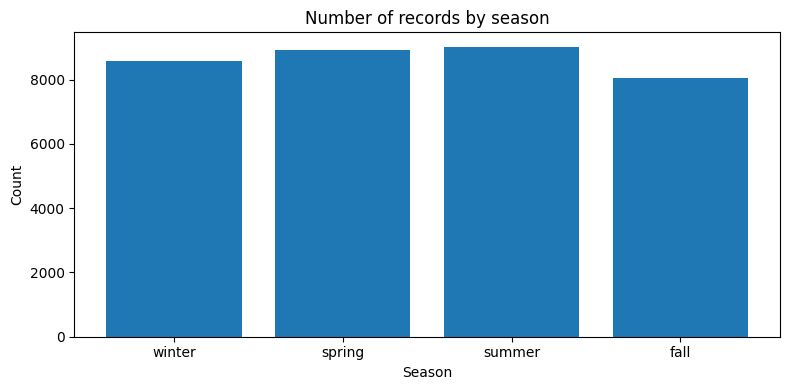

In [12]:
# Histogram / bar chart: records por estação
season_order = ["winter", "spring", "summer", "fall"]

season_counts = (
    hourly_df["season"]
    .astype(str)
    .value_counts()
    .reindex(season_order)
    .fillna(0)
)

plt.figure(figsize=(8, 4))
plt.bar(season_counts.index, season_counts.values)
plt.title("Number of records by season")
plt.xlabel("Season")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

We got a good, balance distributions of season.

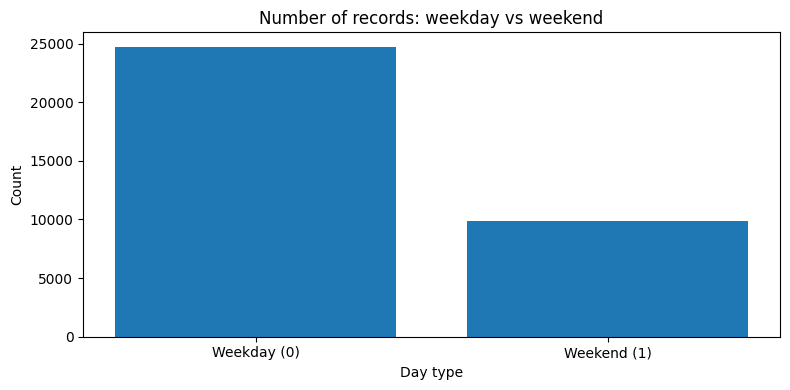

In [13]:
# Histogram / bar chart: semana vs fim de semana
weekend_counts = (
    hourly_df["is_weekend"]
    .value_counts()
    .reindex([0, 1])
    .fillna(0)
)

labels = ["Weekday (0)", "Weekend (1)"]

plt.figure(figsize=(8, 4))
plt.bar(labels, weekend_counts.values)
plt.title("Number of records: weekday vs weekend")
plt.xlabel("Day type")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

Has expected, the amount of weekdays is way bigger then the weekend amount.

In [14]:
# one-hot encoding (create season_spring, season_summer, season_fall, columns fall will be the default, but we will rename it)
hourly_df = pd.get_dummies(hourly_df, columns=["season"], prefix="season", drop_first=True)

hourly_df.head(10)

,Datetime,target_kwh_hour,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,is_weekend,season_spring,season_summer,season_winter
0,2006-12-16 17:00:00,2.533733,0.229000,234.643889,18.100000,0.0,19.0,607.0,1,False,False,False
1,2006-12-16 18:00:00,3.632200,0.080033,234.580167,15.600000,0.0,403.0,1012.0,1,False,False,False
2,2006-12-16 19:00:00,3.400233,0.085233,233.232500,14.503333,0.0,86.0,1001.0,1,False,False,False
3,2006-12-16 20:00:00,3.268567,0.075100,234.071500,13.916667,0.0,0.0,1007.0,1,False,False,False
4,2006-12-16 21:00:00,3.056467,0.076667,237.158667,13.046667,0.0,25.0,1033.0,1,False,False,False
5,2006-12-16 22:00:00,2.200133,0.056167,238.760000,9.523333,0.0,8.0,266.0,1,False,False,False
6,2006-12-16 23:00:00,2.061600,0.071433,240.619667,8.896667,0.0,5.0,0.0,1,False,False,False
7,2006-12-17 00:00:00,1.882467,0.102433,240.961833,8.126667,0.0,28.0,0.0,1,False,False,False
8,2006-12-17 01:00:00,3.349400,0.136933,240.448333,14.246667,0.0,1514.0,0.0,1,False,False,False
9,2006-12-17 02:00:00,1.587267,0.078233,245.818667,6.870000,0.0,34.0,0.0,1,False,False,False


We created 3 new binary features `season_spring`, `season_summer` and `season_winter`. `season_fall` does not exist because it is the default value (all other 3 are false)

## Training Split

In a time-series forecasting problem, the dataset should be split chronologically to avoid data leakage (training on future information). Besides the training and test sets, a validation set is useful because it allows us to choose the best model, features, and hyperparameters using only past data, without “tuning” decisions on the test set. This prevents overly optimistic results caused by repeatedly testing many configurations on the same test period. In practice, the validation set acts as a small “future-like” period inside the training window to check generalization before performing the final, unbiased evaluation on the held-out test set.


In [15]:
hourly_df.to_csv("hourly.csv", index=False)

In [16]:
hourly_df = hourly_df.sort_values("Datetime").copy()
hourly_df["Datetime"] = pd.to_datetime(hourly_df["Datetime"])

start = hourly_df["Datetime"].min()

# 2 anos e 6 meses para treino
train_end = start + pd.DateOffset(years=2, months=6)

# + 6 meses para validação (total 3 anos)
val_end = train_end + pd.DateOffset(months=6)

# resto para teste (deve dar ~9 meses no teu caso)
train2 = hourly_df[hourly_df["Datetime"] < train_end]
val    = hourly_df[(hourly_df["Datetime"] >= train_end) & (hourly_df["Datetime"] < val_end)]
test   = hourly_df[hourly_df["Datetime"] >= val_end]

print("Train period:", train2["Datetime"].min(), "->", train2["Datetime"].max(), "| n =", len(train2))
print("Val period:  ", val["Datetime"].min(),   "->", val["Datetime"].max(),   "| n =", len(val))
print("Test period: ", test["Datetime"].min(),  "->", test["Datetime"].max(),  "| n =", len(test))


# -------------------------
# 2) Features/target
# -------------------------
TARGET = "target_kwh_hour"

# Remover colunas que não devem ir como feature
# (Datetime nunca deve entrar como feature num modelo sklearn destes)
drop_cols = [TARGET, "Datetime"]

X_train = train2.drop(columns=[c for c in drop_cols if c in train2.columns]).copy()
y_train = train2[TARGET].copy()

X_val   = val.drop(columns=[c for c in drop_cols if c in val.columns]).copy()
y_val   = val[TARGET].copy()

X_test  = test.drop(columns=[c for c in drop_cols if c in test.columns]).copy()
y_test  = test[TARGET].copy()

# garantir tudo numérico (bool -> 0/1)
X_train = X_train.astype(float)
X_val   = X_val.astype(float)
X_test  = X_test.astype(float)

Train period: 2006-12-16 17:00:00 -> 2009-06-16 16:00:00 | n = 21912
Val period:   2009-06-16 17:00:00 -> 2009-12-16 16:00:00 | n = 4392
Test period:  2009-12-16 17:00:00 -> 2010-11-26 21:00:00 | n = 8285


In [17]:
X_train.head()

,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,is_weekend,season_spring,season_summer,season_winter
0,0.229000,234.643889,18.100000,0.0,19.0,607.0,1.0,0.0,0.0,0.0
1,0.080033,234.580167,15.600000,0.0,403.0,1012.0,1.0,0.0,0.0,0.0
2,0.085233,233.232500,14.503333,0.0,86.0,1001.0,1.0,0.0,0.0,0.0
3,0.075100,234.071500,13.916667,0.0,0.0,1007.0,1.0,0.0,0.0,0.0
4,0.076667,237.158667,13.046667,0.0,25.0,1033.0,1.0,0.0,0.0,0.0


In [18]:
X_train.dtypes.value_counts()
X_train.select_dtypes(include=["object","datetime64[ns]"]).columns

Index([], dtype='object')

In [19]:
for c in hourly_df.columns:
    if hourly_df[c].dtype == "object":
        print(c, hourly_df[c].unique()[:10])

In [20]:
np.isinf(X_train.to_numpy()).sum(), np.isinf(X_val.to_numpy()).sum(), np.isinf(X_test.to_numpy()).sum()

(0, 0, 0)

In [21]:
hourly_df.isna().sum().sort_values(ascending=False).head(20)

Global_reactive_power    421
Voltage                  421
Global_intensity         421
Datetime                   0
target_kwh_hour            0
Sub_metering_1             0
Sub_metering_2             0
Sub_metering_3             0
is_weekend                 0
season_spring              0
season_summer              0
season_winter              0
dtype: int64

In [22]:
print("NaNs train:", X_train.isna().sum().sort_values(ascending=False).head(15))
print("NaNs val:  ", X_val.isna().sum().sort_values(ascending=False).head(15))
print("NaNs test: ", X_test.isna().sum().sort_values(ascending=False).head(15))
# drop rows with NaNs (keep X/y aligned)
train_mask = ~X_train.isna().any(axis=1)
val_mask   = ~X_val.isna().any(axis=1)
test_mask  = ~X_test.isna().any(axis=1)

X_train, y_train = X_train.loc[train_mask].reset_index(drop=True), y_train.loc[train_mask].reset_index(drop=True)
X_val,   y_val   = X_val.loc[val_mask].reset_index(drop=True),     y_val.loc[val_mask].reset_index(drop=True)
X_test,  y_test  = X_test.loc[test_mask].reset_index(drop=True),   y_test.loc[test_mask].reset_index(drop=True)

print("After drop -> shapes:",
	"train", X_train.shape, y_train.shape,
	"| val", X_val.shape, y_val.shape,
	"| test", X_test.shape, y_test.shape)

print("NaNs train:", X_train.isna().sum().sort_values(ascending=False).head(15))
print("NaNs val:  ", X_val.isna().sum().sort_values(ascending=False).head(15))
print("NaNs test: ", X_test.isna().sum().sort_values(ascending=False).head(15))

NaNs train: Global_reactive_power    116
Voltage                  116
Global_intensity         116
Sub_metering_1             0
Sub_metering_2             0
Sub_metering_3             0
is_weekend                 0
season_spring              0
season_summer              0
season_winter              0
dtype: int64
NaNs val:   Global_reactive_power    14
Voltage                  14
Global_intensity         14
Sub_metering_1            0
Sub_metering_2            0
Sub_metering_3            0
is_weekend                0
season_spring             0
season_summer             0
season_winter             0
dtype: int64
NaNs test:  Global_reactive_power    291
Voltage                  291
Global_intensity         291
Sub_metering_1             0
Sub_metering_2             0
Sub_metering_3             0
is_weekend                 0
season_spring              0
season_summer              0
season_winter              0
dtype: int64
After drop -> shapes: train (21796, 10) (21796,) | val (4378, 10)

The dataset cover 47 months, which translates to 3 years and 9 months. Regarding this we will select a train set size of 3 years and a test size of 9 months. We will split the test size in 84/16 for training and test validation, which corresponds to 2 years 6 months / 6 months

## Baseline model

For the purpose of this model, we want to make a predicition of energy consumption, regarding household eletric data. For this end, it is most suitable to use a regression model.
We will try 

## Models considered

As the goal of this model is to predict the energy consumption, we will assess the following regression models:
- Linear Regression
- Decision Tree Regression
- Random Forest Regression

In this phase, no single model is chosen a priori. We will train and evaluate the three previously selected regression models using the same data split, input features, and evaluation metrics. By comparing their results on the validation set, we can quantify performance differences and select the model that offers the best trade-off between accuracy and generalization.

Pre-trained models were not used. All models were trained from scratch using the training split of the provided dataset. However, we relied on pre-built algorithm implementations available in scikit-learn to ensure robustness, reproducibility, and a fair comparison between approaches. Implementing the models from scratch would significantly increase development time and the likelihood of implementation errors, while offering limited benefit for the scope of this practical work. The effort was therefore directed toward appropriate temporal splitting, feature engineering, and systematic evaluation.

## Why the first apprroach did not work

This first approach is not correct, for multiples reasons:
- Hour, Day of the Week and Months are not cyclical
- Test split contains leakage (Global_reactive_power, Voltage, Global_intensity, Sub_metering_*)
- Poor feature engineering (If we remove this information, we are left with just Date, Season and isWeekend, which only creates seasonal predictions)

## How to correct previous problems

To correct this, there is a need to create new and better features, better aligned with the problem we're trying to solve.

Solve data leakage creating more features.


In [23]:
dfm = hourly_df.copy()
dfm["Datetime"] = pd.to_datetime(dfm["Datetime"])
dfm = dfm.sort_values("Datetime").set_index("Datetime")

# -------------------------
# 1) Features de calendário
# -------------------------
dfm["hour"]  = dfm.index.hour
dfm["dow"]   = dfm.index.dayofweek
dfm["month"] = dfm.index.month

# encoding cíclico (melhor que pôr hour=23 "longe" de hour=0)

dfm["hour_sin"]  = np.sin(2*np.pi*dfm["hour"]/24)
dfm["hour_cos"]  = np.cos(2*np.pi*dfm["hour"]/24)
dfm["dow_sin"]   = np.sin(2*np.pi*dfm["dow"]/7)
dfm["dow_cos"]   = np.cos(2*np.pi*dfm["dow"]/7)
dfm["month_sin"] = np.sin(2*np.pi*dfm["month"]/12)
dfm["month_cos"] = np.cos(2*np.pi*dfm["month"]/12)

# -------------------------
# 2) Lags do target (core!)
# -------------------------

lags = [168, 8736] # daily, weekly, yearly
for lag in lags:
    # Calcula o lag, mas se não existir, usa o valor do momento
    dfm[f"{TARGET}_lag_{lag}"] = dfm[TARGET].shift(lag)

    # Se o valor do lag for NaN (não existe no início), substitui pelo valor da própria hora
    dfm[f"{TARGET}_lag_{lag}"] = dfm[f"{TARGET}_lag_{lag}"].fillna(dfm[TARGET])
    


# -------------------------
# TESTEEEEEEE
# -------------------------

# 2) Rolling do target (sempre shift(1) antes!)

'''
dfm[f"{TARGET}_roll_mean_3"]   = dfm[TARGET].shift(1).rolling(3).mean()
dfm[f"{TARGET}_roll_mean_24"]  = dfm[TARGET].shift(1).rolling(24).mean()
dfm[f"{TARGET}_roll_mean_168"] = dfm[TARGET].shift(1).rolling(168).mean()

# Rolling standard deviation
dfm[f"{TARGET}_roll_std_24"]   = dfm[TARGET].shift(1).rolling(24).std()
dfm[f"{TARGET}_roll_std_168"]  = dfm[TARGET].shift(1).rolling(168).std()

# -------------------------
# Substituir NaN com valor do momento
# -------------------------
dfm[f"{TARGET}_roll_mean_3"]   = dfm[f"{TARGET}_roll_mean_3"].fillna(dfm[TARGET])
dfm[f"{TARGET}_roll_mean_24"]  = dfm[f"{TARGET}_roll_mean_24"].fillna(dfm[TARGET])
dfm[f"{TARGET}_roll_mean_168"] = dfm[f"{TARGET}_roll_mean_168"].fillna(dfm[TARGET])

dfm[f"{TARGET}_roll_std_24"]   = dfm[f"{TARGET}_roll_std_24"].fillna(dfm[TARGET])
dfm[f"{TARGET}_roll_std_168"]  = dfm[f"{TARGET}_roll_std_168"].fillna(dfm[TARGET])
'''

sensor_cols = [
    "Global_reactive_power", "Voltage", "Global_intensity",
    "Sub_metering_1", "Sub_metering_2", "Sub_metering_3"
]


'''
for col in sensor_cols:
    dfm[f"{col}_lag_1"]  = dfm[col].shift(1)
    dfm[f"{col}_lag_24"] = dfm[col].shift(24)
'''

# 4) Season: one-hot (se quiseres manter)

if "season" in dfm.columns:
    dfm = pd.get_dummies(dfm, columns=["season"], prefix="season", drop_first=True)

# -------------------------
# 5)
# remover as colunas "do momento" que causam nowcasting/leakage
# -------------------------

cols_to_drop_now = sensor_cols + ["hour", "dow", "month"]  # hour/dow/month já estão nos sin/cos
for c in cols_to_drop_now:
    if c in dfm.columns:
        dfm = dfm.drop(columns=c)

dfm.shape

(34589, 13)

In [24]:
dfm.head()

,target_kwh_hour,is_weekend,season_spring,season_summer,season_winter,hour_sin,hour_cos,dow_sin,dow_cos,month_sin,month_cos,target_kwh_hour_lag_168,target_kwh_hour_lag_8736
Datetime,,,,,,,,,,,,,
2006-12-16 17:00:00,2.533733,1,False,False,False,-0.965926,-2.588190e-01,-0.974928,-0.222521,-2.449294e-16,1.0,2.533733,2.533733
2006-12-16 18:00:00,3.632200,1,False,False,False,-1.000000,-1.836970e-16,-0.974928,-0.222521,-2.449294e-16,1.0,3.632200,3.632200
2006-12-16 19:00:00,3.400233,1,False,False,False,-0.965926,2.588190e-01,-0.974928,-0.222521,-2.449294e-16,1.0,3.400233,3.400233
2006-12-16 20:00:00,3.268567,1,False,False,False,-0.866025,5.000000e-01,-0.974928,-0.222521,-2.449294e-16,1.0,3.268567,3.268567
2006-12-16 21:00:00,3.056467,1,False,False,False,-0.707107,7.071068e-01,-0.974928,-0.222521,-2.449294e-16,1.0,3.056467,3.056467


In [25]:
dfm.isna().sum().sort_values(ascending=False)

target_kwh_hour             0
is_weekend                  0
season_spring               0
season_summer               0
season_winter               0
hour_sin                    0
hour_cos                    0
dow_sin                     0
dow_cos                     0
month_sin                   0
month_cos                   0
target_kwh_hour_lag_168     0
target_kwh_hour_lag_8736    0
dtype: int64

In [26]:
dfm.shape

(34589, 13)

In [27]:
y = dfm[TARGET].copy()
X = dfm.drop(columns=[TARGET]).copy()

X.dtypes.value_counts(), X.shape, y.shape

(float64    8
 bool       3
 int64      1
 Name: count, dtype: int64,
 (34589, 12),
 (34589,))

In [28]:
start = dfm.index.min()

train_end = start + pd.DateOffset(years=3, months=0)
val_end   = train_end + pd.DateOffset(months=6)

X_train = X[X.index < train_end]
y_train = y[y.index < train_end]

X_val   = X[(X.index >= train_end) & (X.index < val_end)]
y_val   = y[(y.index >= train_end) & (y.index < val_end)]

X_test  = X[X.index >= val_end]
y_test  = y[y.index >= val_end]

print("Train:", X_train.index.min(), "->", X_train.index.max(), "n=", len(X_train))
print("Val:  ", X_val.index.min(),   "->", X_val.index.max(),   "n=", len(X_val))
print("Test: ", X_test.index.min(),  "->", X_test.index.max(),  "n=", len(X_test))

Train: 2006-12-16 17:00:00 -> 2009-12-16 16:00:00 n= 26304
Val:   2009-12-16 17:00:00 -> 2010-06-16 16:00:00 n= 4368
Test:  2010-06-16 17:00:00 -> 2010-11-26 21:00:00 n= 3917


In [29]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# baseline 3: mesma hora da semana anterior
pred_val_week = X_val[f"{TARGET}_lag_168"]
erro_mensal_week = abs(sum(pred_val_week) - sum(y_val)) / sum(y_val) * 100
print("Baseline week-ago | MAE:", mean_absolute_error(y_val, pred_val_week),
      "| RMSE:", rmse(y_val, pred_val_week),
      " | Erro mensal day-ago (%):", erro_mensal_week)

Baseline week-ago | MAE: 0.6498868437118437 | RMSE: 0.9328555667332569  | Erro mensal day-ago (%): 0.8559550607297931


In [30]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor

models = {
    "LinearRegression": Pipeline([
        ("scaler", StandardScaler()),
        ("model", LinearRegression())
    ]),
    "HistGB": HistGradientBoostingRegressor(
        max_depth=8, learning_rate=0.05, max_iter=300, random_state=42
    ),
    "RandomForest": RandomForestRegressor(
        n_estimators=300, random_state=42, n_jobs=-1
    ),
}

for name, model in models.items():
    model.fit(X_train, y_train)
    pred_val = model.predict(X_val)
    erro_mensal = abs(sum(pred_val) - sum(y_val)) / sum(y_val) * 100

    print(f"\n== {name} ==")
    print("VAL | MAE:", mean_absolute_error(y_val, pred_val),
          "| RMSE:", rmse(y_val, pred_val),
          "| Erro mensal (%):", erro_mensal
		  )


== LinearRegression ==
VAL | MAE: 0.5557796439161716 | RMSE: 0.7530189038998862 | Erro mensal (%): 0.9264731061380591

== HistGB ==
VAL | MAE: 0.5282152291861847 | RMSE: 0.7307941248455249 | Erro mensal (%): 1.4362818271192113

== RandomForest ==
VAL | MAE: 0.5441053002899877 | RMSE: 0.746109059241776 | Erro mensal (%): 2.793771910041248


In [31]:
val_df = pd.DataFrame({"y_true": y_val, "y_pred": models["HistGB"].predict(X_val)}, index=y_val.index)

monthly = val_df.resample("ME").sum()
monthly["abs_error_kwh"] = (monthly["y_pred"] - monthly["y_true"]).abs()
monthly["pct_error"] = monthly["abs_error_kwh"] / monthly["y_true"] * 100
monthly[["y_true","y_pred","abs_error_kwh","pct_error"]]

,y_true,y_pred,abs_error_kwh,pct_error
Datetime,,,,
2009-12-31,514.145700,484.866330,29.279370,5.694761
2010-01-31,989.660967,1064.111842,74.450875,7.522867
2010-02-28,924.528433,864.047746,60.480687,6.541788
2010-03-31,802.598300,903.254679,100.656379,12.541315
2010-04-30,739.635400,832.256224,92.620824,12.522497
2010-05-31,814.873333,766.688662,48.184671,5.913149
2010-06-30,379.151433,323.546202,55.605231,14.665705


meter mais lags, porque?
1) Transições dentro do dia (3h, 6h, 12h)
3h e 6h ajudam a modelar “subidas/descidas” típicas (fim da tarde → noite, manhã → almoço).
12h é muito útil porque:
consumo às 8h muitas vezes relaciona-se com o consumo às 20h (rotinas “simétricas” dia/noite)
ou pelo menos ajuda o modelo a perceber o “estado do dia”.
Sem estes lags, o modelo tem de inferir estas transições só com rolling means e calendário, o que nem sempre chega.
2) Memória de curto-médio prazo (48h, 72h)
48h = “mesma hora há 2 dias”
72h = “mesma hora há 3 dias”
Isto ajuda muito quando:
ontem foi um dia estranho (jantar fora, visita, ausência)
mas há 2/3 dias o padrão era mais “normal”
e o modelo consegue “não se agarrar” demasiado ao dia anterior.
Também ajuda a capturar padrões de “vários dias seguidos” (tipo férias, doença, trabalho remoto…).

Depois do teste não deram melhores resultados, até deram pior, assumimos que está a introduzir ruído ao modelo

explicar que opções temos agora:
- Neste momento estamos a faker leakeage, ao preencher os valores nulos de lag_168 e lag_8763. Fazemos isto para testar modelos baseline, como regressão linear, e random forest. Para avançarmos, precisamos de utilizar um modelo que suporta valores NaN, como o HistGBST
- Ou seja, no momento da previsão apenas temos valores do calendario, estacao do ano, se é fim de semana e lags. Para tornar a análise mais profunda, podemos adicionar features de temperatura, que impactam radicalmente a previsão do consumo de energia. Para propósitos académicos, vamos utilizar dados históricos, para entender como o modelo beneficia com esta informação. É verdade que estamos a descrever o melhor caso, porque estas previsões históricas acontecer realmente, enquanto que a previsão meteorolgica tem um erro associado. Em produção esta previsão iria impactar diretamente a nossa previsão, por isso convém ter isso em atenção daqui para a frente. Estamos a olhar para o melhor caso possível.

In [32]:
"""
Historical weather from Sceaux, França
"""

import pandas as pd
import requests

# Sceaux, France (7km from Paris) coordinates
LAT = 48.7781
LON = 2.2890

def fetch_weather_data():
    """Open-Meteo Archive API"""
    
    base_url = "https://archive-api.open-meteo.com/v1/archive"
    
    params = {
        "latitude": LAT,
        "longitude": LON,
        "start_date": "2006-12-16",
        "end_date": "2010-11-16",
        "hourly": ",".join([
            "temperature_2m",
            "relative_humidity_2m", 
            "precipitation",
            "cloud_cover",
            "wind_speed_10m",
            "is_day"
        ]),
        "timezone": "Europe/Paris"
    }
    
    print("Fetching weather data from Open-Meteo Archive...")
    response = requests.get(base_url, params=params, timeout=120)
    response.raise_for_status()
    data = response.json()
    
    # Converter para DataFrame
    hourly = data["hourly"]
    weather_df = pd.DataFrame({
        "Datetime": pd.to_datetime(hourly["time"]),
        "temperature": hourly["temperature_2m"],
        "humidity": hourly["relative_humidity_2m"],
        "precipitation": hourly["precipitation"],
        "cloud_cover": hourly["cloud_cover"],
        "wind_speed": hourly["wind_speed_10m"],
        "is_day": hourly["is_day"]
    })
    if "temperature" in df.columns:
        weather_df["heating_degree"] = np.maximum(0, 18 - weather_df["temperature"])
        weather_df["cooling_degree"] = np.maximum(0, weather_df["temperature"] - 24)
    
    # Saving
    #weather_df.to_csv("weather_sceaux_2006_2010.csv", index=False)
    #print(f"Dados guardados em weather_sceaux_2006_2010.csv")
    print(f"Shape: {weather_df.shape}")
    print(f"Period: {weather_df['Datetime'].min()} -> {weather_df['Datetime'].max()}")
    
    return weather_df


In [33]:
weather_df = fetch_weather_data()
print("\nStats:")
weather_df.describe()

Fetching weather data from Open-Meteo Archive...
Shape: (34368, 7)
Period: 2006-12-16 00:00:00 -> 2010-11-16 23:00:00

Stats:


,Datetime,temperature,humidity,precipitation,cloud_cover,wind_speed,is_day
count,34368,34368.000000,34368.000000,34368.000000,34368.000000,34368.000000,34368.000000
mean,2008-11-30 23:30:00,11.185777,76.542045,0.072509,66.050192,12.889333,0.512628
min,2006-12-16 00:00:00,-10.500000,23.000000,0.000000,0.000000,0.000000,0.000000
25%,2007-12-08 23:45:00,6.200000,66.000000,0.000000,34.000000,8.000000,0.000000
50%,2008-11-30 23:30:00,11.300000,80.000000,0.000000,83.000000,11.700000,1.000000
75%,2009-11-23 23:15:00,16.200000,89.000000,0.000000,100.000000,16.600000,1.000000
max,2010-11-16 23:00:00,34.700000,100.000000,7.200000,100.000000,51.700000,1.000000
std,NaN,6.968054,15.273536,0.289423,36.881010,6.453055,0.499848


In [34]:
weather_df.head(20)

,Datetime,temperature,humidity,precipitation,cloud_cover,wind_speed,is_day
0,2006-12-16 00:00:00,5.2,92,0.0,8,18.6,0
1,2006-12-16 01:00:00,5.0,93,0.0,63,17.3,0
2,2006-12-16 02:00:00,5.0,93,0.0,92,16.1,0
3,2006-12-16 03:00:00,5.2,94,0.0,100,15.9,0
4,2006-12-16 04:00:00,5.5,94,0.0,98,15.5,0
5,2006-12-16 05:00:00,6.0,93,0.0,95,15.6,0
6,2006-12-16 06:00:00,5.9,94,0.0,98,16.2,0
7,2006-12-16 07:00:00,5.8,94,0.0,100,17.5,0
8,2006-12-16 08:00:00,6.1,93,0.0,100,18.6,0
9,2006-12-16 09:00:00,6.1,92,0.0,100,19.5,1


In [35]:
dfm2 = hourly_df.copy()
dfm2["Datetime"] = pd.to_datetime(dfm2["Datetime"])
dfm2 = dfm2.sort_values("Datetime").set_index("Datetime")

dfm2["hour"]  = dfm2.index.hour
dfm2["dow"]   = dfm2.index.dayofweek
dfm2["month"] = dfm2.index.month


dfm2["hour_sin"]  = np.sin(2*np.pi*dfm2["hour"]/24)
dfm2["hour_cos"]  = np.cos(2*np.pi*dfm2["hour"]/24)
dfm2["dow_sin"]   = np.sin(2*np.pi*dfm2["dow"]/7)
dfm2["dow_cos"]   = np.cos(2*np.pi*dfm2["dow"]/7)
dfm2["month_sin"] = np.sin(2*np.pi*dfm2["month"]/12)
dfm2["month_cos"] = np.cos(2*np.pi*dfm2["month"]/12)

lags = [720, 8760] #weekly, yearly
for lag in lags:
    dfm2[f"{TARGET}_lag_{lag}"] = dfm2[TARGET].shift(lag)


sensor_cols = [
    "Global_reactive_power", "Voltage", "Global_intensity",
    "Sub_metering_1", "Sub_metering_2", "Sub_metering_3"
]

if "season" in dfm.columns:
    dfm2 = pd.get_dummies(dfm2, columns=["season"], prefix="season", drop_first=True)


cols_to_drop_now = sensor_cols + ["hour", "dow", "month"]
for c in cols_to_drop_now:
    if c in dfm2.columns:
        dfm2 = dfm2.drop(columns=c)

In [36]:
import pandas as pd

def ensure_datetime_index(df, col="Datetime"):
    out = df.copy()
    if col in out.columns:
        out[col] = pd.to_datetime(out[col])
        out = out.sort_values(col).set_index(col)
    else:
        out.index = pd.to_datetime(out.index)
        out = out.sort_index()
        out.index.name = col
    return out

hourly  = ensure_datetime_index(dfm2)
weather = ensure_datetime_index(weather_df)


In [37]:
start, end = hourly.index.min(), hourly.index.max()

weather_aligned = weather.loc[start:end].reindex(hourly.index).ffill().bfill()

merged_df = hourly.join(weather_aligned, how="left")
merged_df.head()

,target_kwh_hour,is_weekend,season_spring,season_summer,season_winter,hour_sin,hour_cos,dow_sin,dow_cos,month_sin,month_cos,target_kwh_hour_lag_720,target_kwh_hour_lag_8760,temperature,humidity,precipitation,cloud_cover,wind_speed,is_day
Datetime,,,,,,,,,,,,,,,,,,,
2006-12-16 17:00:00,2.533733,1,False,False,False,-0.965926,-2.588190e-01,-0.974928,-0.222521,-2.449294e-16,1.0,NaN,NaN,6.6,93.0,0.8,100.0,12.9,0.0
2006-12-16 18:00:00,3.632200,1,False,False,False,-1.000000,-1.836970e-16,-0.974928,-0.222521,-2.449294e-16,1.0,NaN,NaN,6.3,93.0,0.2,100.0,12.3,0.0
2006-12-16 19:00:00,3.400233,1,False,False,False,-0.965926,2.588190e-01,-0.974928,-0.222521,-2.449294e-16,1.0,NaN,NaN,6.1,92.0,0.0,90.0,11.1,0.0
2006-12-16 20:00:00,3.268567,1,False,False,False,-0.866025,5.000000e-01,-0.974928,-0.222521,-2.449294e-16,1.0,NaN,NaN,5.8,91.0,0.0,72.0,9.0,0.0
2006-12-16 21:00:00,3.056467,1,False,False,False,-0.707107,7.071068e-01,-0.974928,-0.222521,-2.449294e-16,1.0,NaN,NaN,5.0,92.0,0.0,56.0,6.6,0.0


In [38]:
merged_df.shape

(34589, 19)

In [39]:
y = merged_df[TARGET].copy()
X = merged_df.drop(columns=[TARGET]).copy()

start = merged_df.index.min()

train_end = start + pd.DateOffset(years=3, months=0)
val_end   = train_end + pd.DateOffset(months=6)

X_train_m = X[X.index < train_end]
y_train_m = y[y.index < train_end]

X_val_m   = X[(X.index >= train_end) & (X.index < val_end)]
y_val_m  = y[(y.index >= train_end) & (y.index < val_end)]

X_test_m  = X[X.index >= val_end]
y_test_m  = y[y.index >= val_end]

print("Train:", X_train_m.index.min(), "->", X_train_m.index.max(), "n=", len(X_train_m))
print("Val:  ", X_val_m.index.min(),   "->", X_val_m.index.max(),   "n=", len(X_val_m))
print("Test: ", X_test_m.index.min(),  "->", X_test_m.index.max(),  "n=", len(X_test_m))

Train: 2006-12-16 17:00:00 -> 2009-12-16 16:00:00 n= 26304
Val:   2009-12-16 17:00:00 -> 2010-06-16 16:00:00 n= 4368
Test:  2010-06-16 17:00:00 -> 2010-11-26 21:00:00 n= 3917


In [40]:
X_train_m.head()

,is_weekend,season_spring,season_summer,season_winter,hour_sin,hour_cos,dow_sin,dow_cos,month_sin,month_cos,target_kwh_hour_lag_720,target_kwh_hour_lag_8760,temperature,humidity,precipitation,cloud_cover,wind_speed,is_day
Datetime,,,,,,,,,,,,,,,,,,
2006-12-16 17:00:00,1,False,False,False,-0.965926,-2.588190e-01,-0.974928,-0.222521,-2.449294e-16,1.0,NaN,NaN,6.6,93.0,0.8,100.0,12.9,0.0
2006-12-16 18:00:00,1,False,False,False,-1.000000,-1.836970e-16,-0.974928,-0.222521,-2.449294e-16,1.0,NaN,NaN,6.3,93.0,0.2,100.0,12.3,0.0
2006-12-16 19:00:00,1,False,False,False,-0.965926,2.588190e-01,-0.974928,-0.222521,-2.449294e-16,1.0,NaN,NaN,6.1,92.0,0.0,90.0,11.1,0.0
2006-12-16 20:00:00,1,False,False,False,-0.866025,5.000000e-01,-0.974928,-0.222521,-2.449294e-16,1.0,NaN,NaN,5.8,91.0,0.0,72.0,9.0,0.0
2006-12-16 21:00:00,1,False,False,False,-0.707107,7.071068e-01,-0.974928,-0.222521,-2.449294e-16,1.0,NaN,NaN,5.0,92.0,0.0,56.0,6.6,0.0


In [41]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor

models = {
    "HistGB": HistGradientBoostingRegressor(
        max_depth=8, learning_rate=0.05, max_iter=300, random_state=42
    ),
}

for name, model in models.items():
    model.fit(X_train_m, y_train_m)
    pred_val_m = model.predict(X_val_m)
    erro_mensal_m = abs(sum(pred_val_m) - sum(y_val_m)) / sum(y_val_m) * 100

    print(f"\n== {name} ==")
    print("VAL | MAE:", mean_absolute_error(y_val_m, pred_val_m),
          "| RMSE:", rmse(y_val_m, pred_val_m),
          "| Erro mensal (%):", erro_mensal_m
		  )


== HistGB ==
VAL | MAE: 0.5145904844140251 | RMSE: 0.7000168182336709 | Erro mensal (%): 1.8396788514553155


In [42]:
val_df_m = pd.DataFrame({"y_true": y_val_m, "y_pred": models["HistGB"].predict(X_val_m)}, index=y_val_m.index)

monthly = val_df_m.resample("ME").sum()
monthly["abs_error_kwh"] = (monthly["y_pred"] - monthly["y_true"]).abs()
monthly["pct_error"] = monthly["abs_error_kwh"] / monthly["y_true"] * 100
monthly[["y_true","y_pred","abs_error_kwh","pct_error"]]

,y_true,y_pred,abs_error_kwh,pct_error
Datetime,,,,
2009-12-31,514.145700,504.116604,10.029096,1.950633
2010-01-31,989.660967,1067.023284,77.362317,7.817053
2010-02-28,924.528433,875.604612,48.923821,5.291760
2010-03-31,802.598300,926.943794,124.345494,15.492868
2010-04-30,739.635400,769.408709,29.773309,4.025403
2010-05-31,814.873333,766.912841,47.960493,5.885638
2010-06-30,379.151433,349.595658,29.555775,7.795243


Testar outros modelos de forma iterativa e perceber qual dá o melho resultado

In [43]:
merged_df.to_csv("merged_with_weather.csv", index=True)

In [44]:
import pandas as pd
import numpy as np
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
import warnings
warnings.filterwarnings('ignore')

try:
    import lightgbm as lgb
    HAS_LIGHTGBM = True
    print("✅ LightGBM available")
except ImportError:
    HAS_LIGHTGBM = False
    print("⚠️ LightGBM not installed (pip install lightgbm)")

try:
    import xgboost as xgb
    HAS_XGBOOST = True
    print("✅ XGBoost available")
except ImportError:
    HAS_XGBOOST = False
    print("⚠️ XGBoost not installed (pip install xgboost)")

try:
    from catboost import CatBoostRegressor
    HAS_CATBOOST = True
    print("✅ CatBoost available")
except ImportError:
    HAS_CATBOOST = False
    print("⚠️ CatBoost not installed (pip install catboost)")

✅ LightGBM available
✅ XGBoost available
⚠️ CatBoost not installed (pip install catboost)


In [45]:
def erro_percentual(y_true, y_pred):
    """Agregated Percentual Error (each month)"""
    return abs(y_pred.sum() - y_true.sum()) / y_true.sum() * 100

In [46]:
def get_models():
    models = {}
    
    models["HistGB_default"] = HistGradientBoostingRegressor(
        random_state=42
    )
    
    models["HistGB_deep"] = HistGradientBoostingRegressor(
        max_depth=12,
        learning_rate=0.05,
        max_iter=500,
        l2_regularization=0.1,
        random_state=42
    )
    
    models["HistGB_shallow"] = HistGradientBoostingRegressor(
        max_depth=4,
        learning_rate=0.1,
        max_iter=300,
        l2_regularization=1.0,
        random_state=42
    )
    
    models["HistGB_tuned"] = HistGradientBoostingRegressor(
        max_depth=8,
        learning_rate=0.03,
        max_iter=500,
        min_samples_leaf=20,
        l2_regularization=0.5,
        random_state=42,
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=30
    )
    
    if HAS_LIGHTGBM:
        models["LightGBM_default"] = lgb.LGBMRegressor(
            random_state=42,
            verbosity=-1
        )
        
        models["LightGBM_tuned"] = lgb.LGBMRegressor(
            n_estimators=500,
            max_depth=8,
            learning_rate=0.05,
            num_leaves=31,
            min_child_samples=20,
            reg_alpha=0.1,
            reg_lambda=0.1,
            random_state=42,
            verbosity=-1
        )
        
        models["LightGBM_deep"] = lgb.LGBMRegressor(
            n_estimators=1000,
            max_depth=15,
            learning_rate=0.02,
            num_leaves=63,
            min_child_samples=10,
            random_state=42,
            verbosity=-1
        )

    if HAS_XGBOOST:
        models["XGBoost_default"] = xgb.XGBRegressor(
            tree_method="hist",
            enable_categorical=False,
            random_state=42,
            verbosity=0
        )
        
        models["XGBoost_tuned"] = xgb.XGBRegressor(
            n_estimators=500,
            max_depth=8,
            learning_rate=0.05,
            tree_method="hist",
            reg_alpha=0.1,
            reg_lambda=1.0,
            random_state=42,
            verbosity=0
        )

    if HAS_CATBOOST:
        models["CatBoost_default"] = CatBoostRegressor(
            random_state=42,
            verbose=0
        )
        
        models["CatBoost_tuned"] = CatBoostRegressor(
            iterations=500,
            depth=8,
            learning_rate=0.05,
            l2_leaf_reg=3.0,
            random_state=42,
            verbose=0
        )
    
    return models

In [47]:
def temporal_cv_evaluate(model, X, y, n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    mae_scores = []
    rmse_scores = []
    erro_pct_scores = []
    
    for train_idx, val_idx in tscv.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        model.fit(X_train, y_train)
        pred = model.predict(X_val)
        
        mae_scores.append(mean_absolute_error(y_val, pred))
        rmse_scores.append(rmse(y_val, pred))
        erro_pct_scores.append(erro_percentual(y_val, pred))
    
    return {
        "MAE_mean": np.mean(mae_scores),
        "MAE_std": np.std(mae_scores),
        "RMSE_mean": np.mean(rmse_scores),
        "RMSE_std": np.std(rmse_scores),
        "ErroPct_mean": np.mean(erro_pct_scores),
        "ErroPct_std": np.std(erro_pct_scores)
    }

In [48]:
def run_automl(X_train, y_train, X_val, y_val, cv_splits=5):
    """
    Tests all models and returns ranking
    """
    models = get_models()
    results = []
    
    print("\n" + "="*70)
    print("AUTOML - TESTING")
    print("="*70)
    print(f"\Models to test: {len(models)}")
    print(f"Train: {len(X_train)} records")
    print(f"Validation: {len(X_val)} records")
    print(f"Cross-validation: {cv_splits} splits")
    
    for name, model in models.items():
        print(f"\n{'─'*50}")
        print(f" Testing: {name}")
        
        try:
            # Cross-validation training
            cv_results = temporal_cv_evaluate(
                model.__class__(**model.get_params()),  # Clone fresh
                X_train, y_train, 
                n_splits=cv_splits
            )
            
            model.fit(X_train, y_train)
            pred_val = model.predict(X_val)
            
            val_mae = mean_absolute_error(y_val, pred_val)
            val_rmse = rmse(y_val, pred_val)
            val_erro_pct = erro_percentual(y_val, pred_val)
            
            results.append({
                "model": name,
                "CV_MAE": cv_results["MAE_mean"],
                "CV_MAE_std": cv_results["MAE_std"],
                "CV_RMSE": cv_results["RMSE_mean"],
                "Val_MAE": val_mae,
                "Val_RMSE": val_rmse,
                "Val_ErroPct": val_erro_pct
            })
            
            print(f"   CV MAE: {cv_results['MAE_mean']:.4f} (±{cv_results['MAE_std']:.4f})")
            print(f"   Val MAE: {val_mae:.4f} | RMSE: {val_rmse:.4f} | Erro%: {val_erro_pct:.2f}%")
            
        except Exception as e:
            print(f"   ❌ Erro: {e}")
    
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values("Val_MAE")
    
    return results_df, models

In [49]:
def print_results(results_df):
    print("\n" + "="*70)
    print("FINAL RANKING (order by Val_MAE)")
    print("="*70)
    
    print(f"\n{'Rank':<5} {'Modelo':<25} {'CV_MAE':<12} {'Val_MAE':<10} {'Val_RMSE':<10} {'Erro%':<8}")
    print("─"*75)
    
    for i, row in results_df.iterrows():
        rank = results_df.index.get_loc(i) + 1
        print(f"{rank:<5} {row['model']:<25} {row['CV_MAE']:.4f}±{row['CV_MAE_std']:.3f}  "
              f"{row['Val_MAE']:.4f}     {row['Val_RMSE']:.4f}     {row['Val_ErroPct']:.2f}%")
    
    # Best model
    best = results_df.iloc[0]
    print(f"\n WINNER: {best['model']}")
    print(f"   MAE: {best['Val_MAE']:.4f}")
    print(f"   RMSE: {best['Val_RMSE']:.4f}")
    print(f"   Agregated Error: {best['Val_ErroPct']:.2f}%")

In [50]:
df = merged_df.copy()
df_copy = df.drop(columns=[TARGET]).copy()
feature_cols = df_copy.columns.tolist()

start = df.index.min()
end = df.index.max()
total_days = (end - start).days

# 70% treino, 15% validação, 15% teste
train_end = start + pd.DateOffset(days=int(total_days * 0.7))
val_end = start + pd.DateOffset(days=int(total_days * 0.85))

train = df[df.index <= train_end]
val = df[(df.index > train_end) & (df.index <= val_end)]
test = df[df.index > val_end]

print(f"   Train: {train.index.min().date()} → {train.index.max().date()} ({len(train)} records)")
print(f"   Val:    {val.index.min().date()} → {val.index.max().date()} ({len(val)} records)")
print(f"   Test:  {test.index.min().date()} → {test.index.max().date()} ({len(test)} records)")

# Preparar X, y
X_train = train[feature_cols]
y_train = train[TARGET]
X_val = val[feature_cols]
y_val = val[TARGET]
X_test = test[feature_cols]
y_test = test[TARGET]


results_df, models = run_automl(X_train, y_train, X_val, y_val, cv_splits=5)


print_results(results_df)


print("\n" + "="*70)
print("TESTING WITH WINNER MODEL")
print("="*70)

best_model_name = results_df.iloc[0]["model"]
best_model = models[best_model_name]

# Retreinar no treino+validação
X_train_full = pd.concat([X_train, X_val])
y_train_full = pd.concat([y_train, y_val])

best_model.fit(X_train_full, y_train_full)
pred_test = best_model.predict(X_test)

test_mae = mean_absolute_error(y_test, pred_test)
test_rmse = rmse(y_test, pred_test)
test_erro_pct = erro_percentual(y_test, pred_test)

print(f"\nModel: {best_model_name}")
print(f"MAE (test):  {test_mae:.4f}")
print(f"RMSE (test): {test_rmse:.4f}")
print(f"Agregated error: {test_erro_pct:.2f}%")


#results_df.to_csv("automl_results.csv", index=False)
#print("\n✅ Resultados guardados em automl_results.csv")


print("\n" + "="*70)
print("MONTH PREVIEW (TEST)")
print("="*70)

test_df = pd.DataFrame({
	"y_true": y_test,
	"y_pred": pred_test
}, index=y_test.index)

monthly = test_df.resample("ME").sum()
monthly["abs_error"] = (monthly["y_pred"] - monthly["y_true"]).abs()
monthly["pct_error"] = monthly["abs_error"] / monthly["y_true"] * 100

print(monthly[["y_true", "y_pred", "abs_error", "pct_error"]].round(2).to_string())
print(f"\n Average monthly error rate: {monthly['pct_error'].mean():.2f}%")

   Train: 2006-12-16 → 2009-09-19 (24193 records)
   Val:    2009-09-19 → 2010-04-23 (5184 records)
   Test:  2010-04-23 → 2010-11-26 (5212 records)

AUTOML - TESTING
\Models to test: 9
Train: 24193 records
Validation: 5184 records
Cross-validation: 5 splits

──────────────────────────────────────────────────
 Testing: HistGB_default
   CV MAE: 0.5491 (±0.0873)
   Val MAE: 0.5142 | RMSE: 0.7066 | Erro%: 2.30%

──────────────────────────────────────────────────
 Testing: HistGB_deep
   CV MAE: 0.5576 (±0.0933)
   Val MAE: 0.5197 | RMSE: 0.7143 | Erro%: 2.53%

──────────────────────────────────────────────────
 Testing: HistGB_shallow
   CV MAE: 0.5516 (±0.0897)
   Val MAE: 0.5128 | RMSE: 0.7003 | Erro%: 2.19%

──────────────────────────────────────────────────
 Testing: HistGB_tuned
   CV MAE: 0.5507 (±0.0899)
   Val MAE: 0.5116 | RMSE: 0.7013 | Erro%: 2.35%

──────────────────────────────────────────────────
 Testing: LightGBM_default
   CV MAE: 0.5453 (±0.0866)
   Val MAE: 0.5149 | RM

O melhor modelo é..

Treino progressivo, em blocos, para ver progressão de modelo

In [51]:
def get_season(month):
    """Retorna a estação do ano."""
    if month in [12, 1, 2]:
        return "Inverno"
    elif month in [3, 4, 5]:
        return "Primavera"
    elif month in [6, 7, 8]:
        return "Verão"
    else:
        return "Outono"

In [52]:
def train_and_evaluate(df, train_end, test_start, test_end, target_col, feature_cols):
    """
    Treina modelo até train_end e avalia no período test_start:test_end.
    
    Returns:
        dict com métricas
    """
    # Split
    train = df[df.index <= train_end]
    test = df[(df.index >= test_start) & (df.index <= test_end)]
    
    if len(test) == 0:
        return None
    
    X_train = train[feature_cols]
    y_train = train[target_col]
    X_test = test[feature_cols]
    y_test = test[target_col]
    
    # Modelo
    if HAS_LIGHTGBM:
        model = lgb.LGBMRegressor(
            n_estimators=300,
            max_depth=8,
            learning_rate=0.05,
            random_state=42,
            verbosity=-1
        )
    else:
        model = HistGradientBoostingRegressor(
            max_depth=8,
            learning_rate=0.05,
            max_iter=300,
            random_state=42
        )
    
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    
    # Métricas
    mae = mean_absolute_error(y_test, pred)
    rmse_val = rmse(y_test, pred)
    
    total_true = y_test.sum()
    total_pred = pred.sum()
    erro_pct = abs(total_pred - total_true) / total_true * 100
    
    return {
        "n_train": len(train),
        "n_test": len(test),
        "MAE": mae,
        "RMSE": rmse_val,
        "total_true_kwh": total_true,
        "total_pred_kwh": total_pred,
        "erro_pct": erro_pct
    }

In [53]:

def progressive_evaluation(df, target_col="target_kwh_hour"):
    """
    Avaliação progressiva: treina com cada vez mais dados e testa o mês seguinte.
    """
    start = df.index.min()
    end = df.index.max()
    
    print("="*80)
    print("📊 AVALIAÇÃO PROGRESSIVA - SIMULAÇÃO DE PRODUÇÃO")
    print("="*80)
    print(f"\nDataset: {start.date()} → {end.date()}")
    print(f"Features: {len(feature_cols)}")
    print(f"Modelo: {'HistGradientBoosting'}")
    
    # =========================================================================
    # DEFINIR CENÁRIOS DE TESTE
    # =========================================================================
    
    scenarios = [
        {
            "name": "9 months of training",
            "train_months": 9,
            "description": "Young Model - no/less historical seasonality"
        },
        {
            "name": "1.5 years of training", 
            "train_months": 18,
            "description": "Mature model - some seasonality"
        },
        {
            "name": "2 years 8 months (Authumn)",
            "train_months": 32,
            "description": "Season 1"
        },
        {
            "name": "3 years 1 months (Winter)",
            "train_months": 37,
            "description": "Season 2"
        },
        {
            "name": "3 years 4 months (Spring)",
            "train_months": 40,
            "description": "Season 3"
        },
        {
            "name": "3 years 8 months (Summer)",
            "train_months": 44,
            "description": "Season 4"
        },
    ]
    
    results = []
    
    print("\n" + "─"*80)
    
    for scenario in scenarios:
        train_months = scenario["train_months"]
        
        # Calcular datas
        train_end = start + pd.DateOffset(months=train_months) - pd.Timedelta(hours=1)
        test_start = train_end + pd.Timedelta(hours=1)
        test_end = test_start + pd.DateOffset(months=1) - pd.Timedelta(hours=1)
        
        # Verificar se temos dados suficientes
        if test_end > end:
            print(f"\n⚠️ {scenario['name']}: Not enough data for testing (need until {test_end.date()})")
            continue
        
        # Avaliar
        metrics = train_and_evaluate(
            df, train_end, test_start, test_end, target_col, feature_cols
        )
        
        if metrics is None:
            continue
        
        # Adicionar info do cenário
        test_month = test_start.month
        season = get_season(test_month)
        
        metrics["scenario"] = scenario["name"]
        metrics["train_period"] = f"{start.date()} → {train_end.date()}"
        metrics["test_period"] = f"{test_start.date()} → {test_end.date()}"
        metrics["test_month_name"] = test_start.strftime("%B %Y")
        metrics["season"] = season
        
        results.append(metrics)
        
        # Output
        print(f"\n📅 {scenario['name']}")
        print(f"   {scenario['description']}")
        print(f"   Training: {start.date()} → {train_end.date()} ({metrics['n_train']} hours)")
        print(f"   Test:  {test_start.date()} → {test_end.date()} ({metrics['n_test']} hours)")
        print(f"   Season: {season} | Month: {test_start.strftime('%B %Y')}")
        print(f"   ─────────────────────────────────────")
        print(f"   MAE:  {metrics['MAE']:.4f} kWh")
        print(f"   RMSE: {metrics['RMSE']:.4f} kWh")
        print(f"   Total Real:     {metrics['total_true_kwh']:.0f} kWh")
        print(f"   Total Predicted: {metrics['total_pred_kwh']:.0f} kWh")
        print(f"   Monthly Error:    {metrics['erro_pct']:.2f}%")
    
    # =========================================================================
    # RESUMO FINAL
    # =========================================================================
    
    if not results:
        print("\n❌ Insuficient data")
        return None
    
    results_df = pd.DataFrame(results)
    
    print("\n" + "="*80)
    print("FINAL SUMMARY")
    print("="*80)
    
    print("\n┌─────────────────────────────────────┬──────────┬────────────┬───────────┐")
    print("│ Scenario                             │ N_train │   MAE      │  Error %  │")
    print("├─────────────────────────────────────┼──────────┼────────────┼───────────┤")
    
    for _, row in results_df.iterrows():
        print(f"│ {row['scenario']:<35} │ {row['n_train']:>8} │ {row['MAE']:>10.4f} │ {row['erro_pct']:>8.2f}% │")
    
    print("└─────────────────────────────────────┴──────────┴────────────┴───────────┘")
    
    
    return results_df

In [54]:
results = progressive_evaluation(merged_df, TARGET)

📊 AVALIAÇÃO PROGRESSIVA - SIMULAÇÃO DE PRODUÇÃO

Dataset: 2006-12-16 → 2010-11-26
Features: 18
Modelo: HistGradientBoosting

────────────────────────────────────────────────────────────────────────────────

📅 9 months of training
   Young Model - no/less historical seasonality
   Training: 2006-12-16 → 2007-09-16 (6576 hours)
   Test:  2007-09-16 → 2007-10-16 (720 hours)
   Season: Outono | Month: September 2007
   ─────────────────────────────────────
   MAE:  0.6242 kWh
   RMSE: 0.8206 kWh
   Total Real:     799 kWh
   Total Predicted: 893 kWh
   Monthly Error:    11.71%

📅 1.5 years of training
   Mature model - some seasonality
   Training: 2006-12-16 → 2008-06-16 (13152 hours)
   Test:  2008-06-16 → 2008-07-16 (720 hours)
   Season: Verão | Month: June 2008
   ─────────────────────────────────────
   MAE:  0.4510 kWh
   RMSE: 0.6242 kWh
   Total Real:     643 kWh
   Total Predicted: 594 kWh
   Monthly Error:    7.67%

📅 2 years 8 months (Authumn)
   Season 1
   Training: 2006-12-1

In [55]:
def forecast_month_real(df, target_col, train_end, month_to_forecast):
    """
    Previsão REAL de um mês inteiro.
    
    Simula produção: treina até train_end, prevê mês seguinte sem lags curtos.
    """
    
    # Definir período de previsão
    forecast_start = month_to_forecast
    forecast_end = forecast_start + pd.DateOffset(months=1) - pd.Timedelta(hours=1)
    
    
    # Split
    train = df[df.index <= train_end].copy()
    test = df[(df.index >= forecast_start) & (df.index <= forecast_end)].copy()
    
    if len(test) == 0:
        return None
    
    # Preencher NaN nos lags com valores default
    for col in ["lag_720", "lag_8760"]:
        if col in train.columns:
            train[col] = train[col].fillna(train[col].median() if train[col].notna().any() else 0)
        if col in test.columns:
            # Para teste, usar mediana do treino
            median_val = train[col].median() if train[col].notna().any() else 0
            test[col] = test[col].fillna(median_val)
    
    # Preencher profiles com mediana
    for col in ["hourly_profile", "weekly_profile", "monthly_profile"]:
        if col in train.columns:
            train[col] = train[col].fillna(train[target_col].mean())
        if col in test.columns:
            test[col] = test[col].fillna(train[target_col].mean() if len(train) > 0 else 0)
    
    X_train = train[feature_cols]
    y_train = train.loc[X_train.index, target_col]
    X_test = test[feature_cols]
    y_test = test[target_col]
    
    if len(X_train) < 100:
        print(f"   ⚠️ Insuficient training data: {len(X_train)} records")
        return None
    
    # Treinar modelo
    model = HistGradientBoostingRegressor(
        max_depth=8,
        learning_rate=0.05,
        max_iter=300,
        random_state=42
    )
    model.fit(X_train, y_train)
    
    # Prever
    predictions = model.predict(X_test)
    predictions = np.maximum(0, predictions)  # Consumo não pode ser negativo
    
    # Métricas
    mae = mean_absolute_error(y_test, predictions)
    rmse_val = rmse(y_test, predictions)
    total_true = y_test.sum()
    total_pred = predictions.sum()
    erro_pct = abs(total_pred - total_true) / total_true * 100
    
    return {
        "train_end": train_end,
        "forecast_month": forecast_start.strftime("%Y-%m"),
        "n_train": len(train),
        "n_test": len(test),
        "MAE": mae,
        "RMSE": rmse_val,
        "total_true_kwh": total_true,
        "total_pred_kwh": total_pred,
        "erro_pct": erro_pct,
        "season": get_season(forecast_start.month),
        "features_used": len(feature_cols)
    }

In [56]:
def run_real_production_evaluation(df, target_col="target_kwh_hour"):
    """
    Avaliação completa em cenário de produção real.
    """
    
    print("="*80)
    print("REAL MULTI-STEP PREVIEW")
    print("="*80)
    
    # Detectar período disponível
    start = df.index.min()
    end = df.index.max()
    
    print(f"\n📅 Dataset: {start.date()} → {end.date()}")
    
    # Vamos testar vários meses
    # Começar depois de ter pelo menos 6 meses de histórico (mínimo razoável)
    # Idealmente 1 ano para ter lag_8760
    
    min_history = pd.DateOffset(months=6)  # Mínimo 6 meses de histórico
    first_forecast = start + min_history
    first_forecast = first_forecast.replace(day=1, hour=0, minute=0, second=0)
    
    results = []
    
    # Gerar lista de meses para testar
    current = first_forecast
    while current + pd.DateOffset(months=1) <= end:
        
        # Treino até fim do mês anterior
        train_end = current - pd.Timedelta(hours=1)
        
        result = forecast_month_real(
            df, target_col, train_end, current
        )
        
        if result:
            results.append(result)
            print(f"\n📆 {result['forecast_month']} ({result['season']})")
            print(f"   Training until : {train_end.date()}")
            print(f"   MAE: {result['MAE']:.4f} kWh")
            print(f"   Total Real:     {result['total_true_kwh']:.0f} kWh")
            print(f"   Total Preview: {result['total_pred_kwh']:.0f} kWh")
            print(f"   Monthly Error:    {result['erro_pct']:.2f}%")
        
        current = current + pd.DateOffset(months=1)
    
    if not results:
        print("no records to test")
        return None

    results_df = pd.DataFrame(results)
    
    print("\n" + "="*80)
    print("SUMMARY - MULTI-STEP REAL PREDICTION")
    print("="*80)
    
    print(f"\nPredicted Months: {len(results_df)}")
    print(f"Avg MAE: {results_df['MAE'].mean():.4f} kWh")
    print(f"Avg Monthly Error: {results_df['erro_pct'].mean():.2f}%")
    print(f"Min Monthly Error: {results_df['erro_pct'].min():.2f}%")
    print(f"Max Monthly Error: {results_df['erro_pct'].max():.2f}%")
    
    print("\nBy season:")
    for season in ["Winter", "Spring", "Summer", "Authumn"]:
        season_data = results_df[results_df["season"] == season]
        if len(season_data) > 0:
            print(f"   {season}: {season_data['erro_pct'].mean():.2f}% (n={len(season_data)})")
    
    print("\n" + "="*80)
    print("📊 STATS REAL MULTI-STEP")
    print("="*80)

    
    mean_erro = results_df['erro_pct'].mean()
    mean_mae = results_df['MAE'].mean()
    
    print(f"│ MAE médio          │ {mean_mae:.2f} kWh │")
    print(f"│ Erro mensal médio  │ {mean_erro:.1f}%   │")

    
    return results_df

In [57]:
results = run_real_production_evaluation(merged_df, TARGET)

REAL MULTI-STEP PREVIEW

📅 Dataset: 2006-12-16 → 2010-11-26

📆 2007-06 (Verão)
   Training until : 2007-05-31
   MAE: 0.5196 kWh
   Total Real:     595 kWh
   Total Preview: 681 kWh
   Monthly Error:    14.54%

📆 2007-07 (Verão)
   Training until : 2007-06-30
   MAE: 0.4198 kWh
   Total Real:     495 kWh
   Total Preview: 493 kWh
   Monthly Error:    0.38%

📆 2007-08 (Verão)
   Training until : 2007-07-31
   MAE: 0.5845 kWh
   Total Real:     568 kWh
   Total Preview: 500 kWh
   Monthly Error:    12.04%

📆 2007-09 (Outono)
   Training until : 2007-08-31
   MAE: 0.6768 kWh
   Total Real:     698 kWh
   Total Preview: 948 kWh
   Monthly Error:    35.89%

📆 2007-10 (Outono)
   Training until : 2007-09-30
   MAE: 0.7506 kWh
   Total Real:     821 kWh
   Total Preview: 1138 kWh
   Monthly Error:    38.54%

📆 2007-11 (Outono)
   Training until : 2007-10-31
   MAE: 0.6356 kWh
   Total Real:     932 kWh
   Total Preview: 996 kWh
   Monthly Error:    6.91%

📆 2007-12 (Inverno)
   Training until

In [58]:
def plot_yearly_histograms(results_df):
    """
    Cria histogramas comparando previsão vs real para cada ano.
    """
    import matplotlib.pyplot as plt
    
    # Extrair ano do forecast_month
    results_df = results_df.copy()
    results_df["year"] = results_df["forecast_month"].str[:4].astype(int)
    results_df["month_num"] = results_df["forecast_month"].str[5:7].astype(int)
    
    # Anos disponíveis
    years = sorted(results_df["year"].unique())
    
    # Nomes dos meses
    month_names = ["Jan", "Fev", "Mar", "Abr", "Mai", "Jun", 
                   "Jul", "Ago", "Set", "Out", "Nov", "Dez"]
    
    # Criar figura com subplots
    n_years = len(years)
    fig, axes = plt.subplots(n_years, 1, figsize=(14, 5*n_years))
    
    if n_years == 1:
        axes = [axes]
    
    for idx, year in enumerate(years):
        ax = axes[idx]
        year_data = results_df[results_df["year"] == year].sort_values("month_num")
        
        if len(year_data) == 0:
            continue
        
        months = year_data["month_num"].values
        real_values = year_data["total_true_kwh"].values
        pred_values = year_data["total_pred_kwh"].values
        errors = year_data["erro_pct"].values
        
        # Posições das barras
        x = np.arange(len(months))
        width = 0.35
        
        # Barras
        bars1 = ax.bar(x - width/2, real_values, width, label='Real', color='#2ecc71', alpha=0.8)
        bars2 = ax.bar(x + width/2, pred_values, width, label='Prediction', color='#3498db', alpha=0.8)
        
        # Adicionar erro percentual em cima de cada par de barras
        for i, (r, p, e) in enumerate(zip(real_values, pred_values, errors)):
            max_val = max(r, p)
            color = '#e74c3c' if e > 20 else '#f39c12' if e > 10 else '#27ae60'
            ax.annotate(f'{e:.1f}%', 
                       xy=(i, max_val + 20),
                       ha='center', va='bottom',
                       fontsize=10, fontweight='bold',
                       color=color)
        
        # Configurações do gráfico
        ax.set_xlabel('Month', fontsize=12)
        ax.set_ylabel('Total Consumption (kWh)', fontsize=12)
        ax.set_title(f'Year {year} - Prediction vs Real', fontsize=14, fontweight='bold')
        ax.set_xticks(x)
        ax.set_xticklabels([month_names[m-1] for m in months])
        ax.legend(loc='upper right')
        ax.grid(axis='y', alpha=0.3)
        
        # Calcular estatísticas do ano
        year_mae = year_data["MAE"].mean()
        year_erro = year_data["erro_pct"].mean()
        ax.text(0.02, 0.98, f'AVG MAE: {year_mae:.2f} kWh | Average error: {year_erro:.1f}%',
                transform=ax.transAxes, fontsize=11,
                verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    #plt.savefig('yearly_comparison_histograms.png', dpi=150, bbox_inches='tight')
    plt.show()
    plt.close()
    
    # =========================================================================
    # GRÁFICO ADICIONAL: Evolução do erro ao longo do tempo
    # =========================================================================
    
    fig, ax = plt.subplots(figsize=(14, 6))
    
    # Ordenar por data
    results_sorted = results_df.sort_values("forecast_month")
    
    x = range(len(results_sorted))
    errors = results_sorted["erro_pct"].values
    months = results_sorted["forecast_month"].values
    
    # Cores por estação
    colors = []
    for season in results_sorted["season"]:
        if season == "Winter":
            colors.append('#3498db')  # Azul
        elif season == "Spring":
            colors.append('#2ecc71')  # Verde
        elif season == "Summer":
            colors.append('#f1c40f')  # Amarelo
        else:
            colors.append('#e67e22')  # Laranja
    
    bars = ax.bar(x, errors, color=colors, alpha=0.8, edgecolor='black', linewidth=0.5)
    
    # Linha de tendência (média móvel)
    if len(errors) >= 3:
        window = min(3, len(errors))
        rolling_mean = pd.Series(errors).rolling(window=window, center=True).mean()
        ax.plot(x, rolling_mean, color='red', linewidth=2, linestyle='--', label='Tendência (média móvel)')
    
    # Linhas de referência
    ax.axhline(y=10, color='green', linestyle=':', alpha=0.7, label='Bom (<10%)')
    ax.axhline(y=20, color='orange', linestyle=':', alpha=0.7, label='Aceitável (<20%)')
    
    ax.set_xlabel('Month Prediction', fontsize=12)
    ax.set_ylabel('Monthly Error (%)', fontsize=12)
    ax.set_title('Error Evolution during Time', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(months, rotation=45, ha='right')
    ax.legend(loc='upper right')
    ax.grid(axis='y', alpha=0.3)
    
    # Legenda de cores das estações
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#3498db', label='Inverno'),
        Patch(facecolor='#2ecc71', label='Primavera'),
        Patch(facecolor='#f1c40f', label='Verão'),
        Patch(facecolor='#e67e22', label='Outono'),
    ]
    ax.legend(handles=legend_elements, loc='upper left', title='Estação')
    
    plt.tight_layout()
    #plt.savefig('error_evolution_timeline.png', dpi=150, bbox_inches='tight')
    plt.show()
    plt.close()

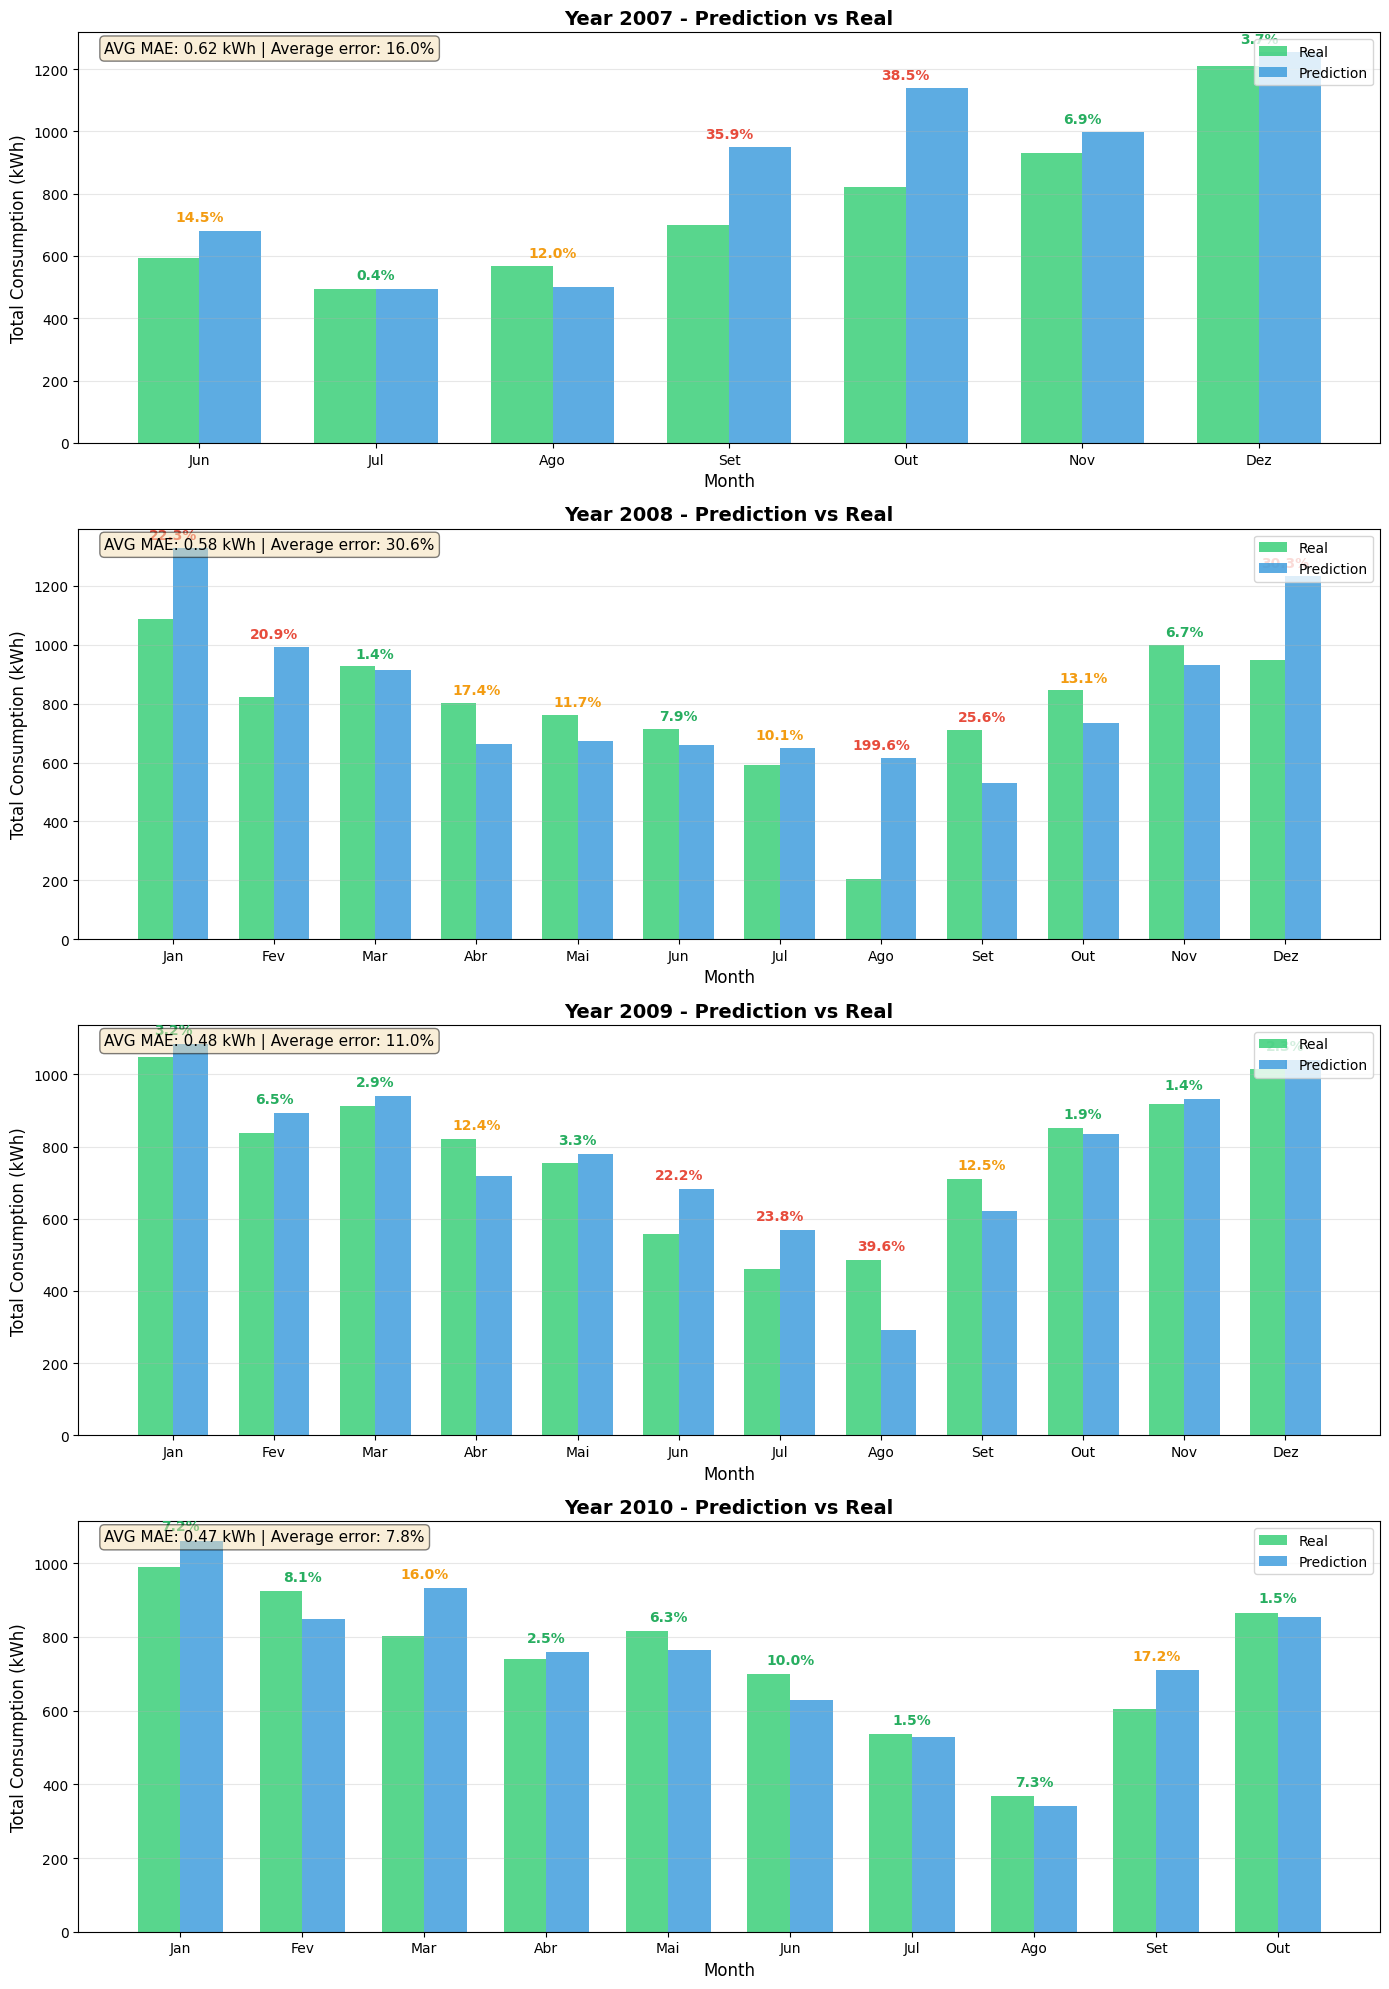

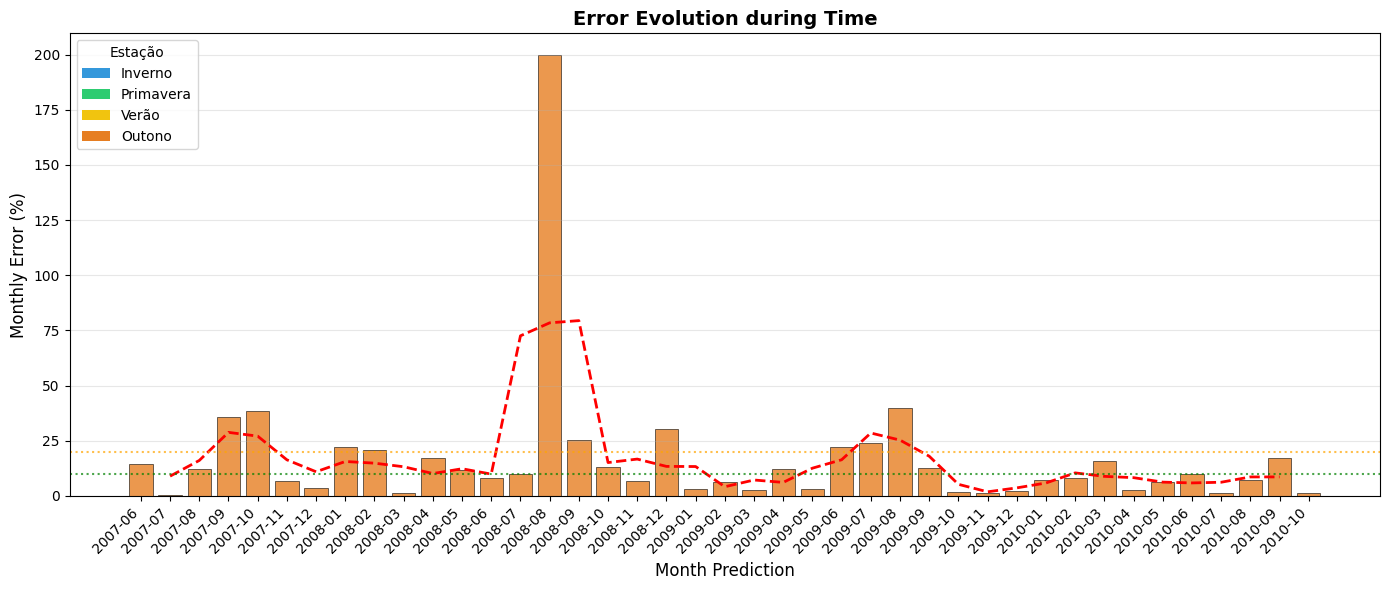

In [59]:
plot_yearly_histograms(results)

## Next Steps

Acrescentar feriados, Férias e Ausencias, Horário de Trabalho, Paineis Solares, Veículo Elétrico.

Utilizar previsão meteorolgica para o mes todo, invés de dados históricos.

Para fazer a previsão de preço, é necessário saber o valor da taxa, esta taxa é calculada diariamente, e sabe-se no dia anterior. Para fazer o cálculo do próximo mês, precisavamos de fazer uma previsão do preço no dia antes da previsão, de modo a ser 100% accurate.

In [ ]:
NOTEBOOK_CODE = ''
# ============================================================================
# 📦 EXPORTAR MODELO PARA DEPLOYMENT
# ============================================================================

import joblib
import pickle
import json
import os

# Criar pasta para o modelo
os.makedirs("model", exist_ok=True)

# 1. Guardar o modelo treinado
# (assumindo que o modelo se chama 'model' ou 'best_model' ou o nome que usaste)

# Se usaste HistGradientBoostingRegressor:
joblib.dump(model, "model/energy_model.pkl")
print("✅ Modelo guardado: model/energy_model.pkl")

# 2. Guardar metadados do modelo (features, etc.)
model_metadata = {
    "target": "target_kwh_hour",
    "features": [
        "is_weekend", "hour_sin", "hour_cos", "dow_sin", "dow_cos",
        "month_sin", "month_cos", "lag_720", "lag_336", "lag_8760",
        "temperature", "humidity", "heating_degree", "cooling_degree"
    ],
    "lags": {
        "lag_720": 720,   # ~1 mês
        "lag_8760": 8760  # ~1 ano
    },
    "model_type": "HistGradientBoostingRegressor",
    "description": "Household Energy Consumption Predictor",
    "version": "1.0"
}

with open("model/model_metadata.json", "w") as f:
    json.dump(model_metadata, f, indent=2)
print("✅ Metadados guardados: model/model_metadata.json")

# 3. Verificar que o modelo foi guardado corretamente
model_loaded = joblib.load("model/energy_model.pkl")
print(f"✅ Modelo verificado: {type(model_loaded).__name__}")

print("\\n📦 Modelo pronto para deployment!")
print("   Ficheiros criados:")
print("   - model/energy_model.pkl")
print("   - model/model_metadata.json")
''

print("="*70)
print("📦 CÓDIGO PARA EXPORTAR O MODELO")
print("="*70)
print("\nCopia o seguinte código para uma célula no final do teu notebook:\n")
print("-"*70)
print(NOTEBOOK_CODE)
print("-"*70)
print("\n✅ Após executar, terás os ficheiros prontos para o FastAPI!")

✅ Modelo guardado: model/energy_model.pkl
✅ Metadados guardados: model/model_metadata.json
✅ Modelo verificado: HistGradientBoostingRegressor
\n📦 Modelo pronto para deployment!
   Ficheiros criados:
   - model/energy_model.pkl
   - model/model_metadata.json
📦 CÓDIGO PARA EXPORTAR O MODELO

Copia o seguinte código para uma célula no final do teu notebook:

----------------------------------------------------------------------

----------------------------------------------------------------------

✅ Após executar, terás os ficheiros prontos para o FastAPI!
